<h1> <center> ENSF 519.01 Applied Data Scince </center></h1>
<h2> <center> Assignment 3: Supervised learning and dimension reduction (25 marks)</center></h2>
<h2> <center> Due: March 9, 2018. To be submitted on D2L Dropbox </center></h2>


In this assignment the focus is on ensemble models for learning and how preprocessing can help improving prediction scores. There are 5 parts that each may use different dataset. All datasets are available as csv files on D2L. 

<h2>Part A. Defect Prediction - Voting Ensemble Model (4 marks)</h2>
<br><br>
In this section you need to repeat what you did in your last assignment, HW2 at Part C, but this time you should use VotingClassifier function of SKlearn rather than the Combine function explained in that assignment.
<br>
Basically, you predict defects on the same NASA dataset using a simple ensemble model consisting of Logistic Regression, Gaussian Naive Bayes, and K-Nearest Neighbor estimators. You need to try both "soft voting" and "hard voting" options. 
<br>
All models and functions should be called by their default parameters.
<br>
Same as HW2, you calculate each combined score 30 times (with different random_state seeds for the train_test_splits).
Finally, visualize the results as three boxplots of 30 runs per: a) soft voting, b) hard voting, and c) your combined model’s results from HW2. 



[Text(0,0.5,'Accuracy'), Text(0.5,0,'Model')]

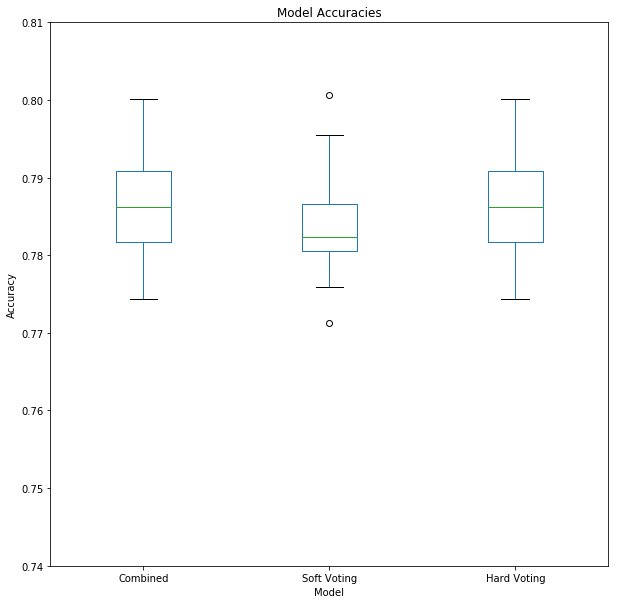

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings

# this function fits and scores the model for random seeds 1-30
def run_model(model, features, labels):
    results = []
    for x in range(1, 31):
        ## split the data into 75% training and 25% testing sets
        X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, test_size=0.25, random_state = x)
        ## fit the model to the training data
        model.fit(X_train, y_train)
        ## score the model on the test data
        results.append(model.score(X_test, y_test))
    return results

def combine(KNN, LR, GNB, features, labels):
    results = []
    ## for each random seed 1-30
    for x in range(1, 31):
        three_results = []
        KNN_results = []
        LR_results = []
        GNB_results = []
        ## split the data into 75% training and 25% testing sets
        X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, test_size=0.25, random_state = x)
        ## fit the models to the training data
        KNN.fit(X_train, y_train)
        LR.fit(X_train, y_train)
        GNB.fit(X_train, y_train)
        ## predict the probabilities with each model
        KNN_results.append(KNN.predict_proba(X_test))
        LR_results.append(LR.predict_proba(X_test))
        GNB_results.append(GNB.predict_proba(X_test))
        three_results = [KNN_results, LR_results, GNB_results]
        successes = 0;
        ## for each row in the data make a prediction
        for y in range(0,len(three_results[0][0])):
            ## get a combined prediction
            prediction = math.ceil((probability(three_results[0][0][y][0]) + probability(three_results[1][0][y][0]) + probability(three_results[2][0][y][0]))/3)
            ## check if the prediction matches the actual label
            if(y_test.iloc[y] == prediction):
                successes = successes + 1;
        ## calculate accuracy for that seed
        results.append(successes/len(three_results[0][0]))
    return results

# return the predicted probability given the class 0 probability
def probability(class_0_prob):
    # if class 0 is more likely, return (-1) class 0 probability
    if(class_0_prob > 0.5):
        return (-1 * class_0_prob)
    # if class 1 is more likely, return (+1) class 1 probability
    else:
        return (1 - class_0_prob)

# combine the results of the three models with soft voting
def soft_voting(KNN, LR, GNB, features, labels):
    VC = VotingClassifier(estimators=[('KNN', KNN), ('LR', LR), ('GNB', GNB)], voting='soft', weights=[1, 1, 1])
    results = run_model(VC, features, labels)
    return results

# combine the results of the three models with hard voting
def hard_voting(KNN, LR, GNB, features, labels):
    VC = VotingClassifier(estimators=[('KNN', KNN), ('LR', LR), ('GNB', GNB)], voting='hard', weights=[1, 1, 1])
    results = run_model(VC, features, labels)
    return results

## hide python warnings
warnings.filterwarnings('ignore')

## read the data 
data = pd.read_csv('NasaData.csv')
## extact the features
features = data.drop('label', axis=1)
## extract the labels
labels = data['label']

results = []

## run the three models combined
results.append(combine(KNeighborsClassifier(), LogisticRegression(), GaussianNB(), features, labels))
results.append(soft_voting(KNeighborsClassifier(), LogisticRegression(), GaussianNB(), features, labels))
results.append(hard_voting(KNeighborsClassifier(), LogisticRegression(), GaussianNB(), features, labels))

## create a Dataframe of the accuracies
df = pd.DataFrame(results).transpose()
df.columns = ['Combined', 'Soft Voting', 'Hard Voting']
## visualize the accuracies for all the models
df.plot.box(figsize=(10, 10),title='Model Accuracies',ylim=(0.74, 0.81)).set(xlabel="Model", ylabel="Accuracy")

<h2>Part B. Linear Regression, Random Forest, and Gradient Boosting (5 marks) </h2>

In this section, our task is again defect prediction. However, this time each artifact may have zero, one, or more defects. Thus our job is not just predicting defective vs. non-defective targets, but we would like to predict the exact number of defects. This is useful since one can prioritize QA effort based on the number of defects as a sign of severity. To do so we treat the problem as a regression problem not a classification problem.

- <b> If we would use a classification rather than regression, explain what kind of classification problem this question could fit in and why? Explain why a regression solution is a better choice.



<b>Your Answer:</b> This would only make sense as a classification problem if we had discrete classes of severity (e.g. not severe, moderately severe, very severe). A regression solution is better choice because the number of bugs is a continuous measurement in the set of natural numbers. Regression works better when the y values are continuous rather than discrete classes. 

To build your models you should follow these steps: 
<br>
- read the data from "OO-DefectPrediction.csv" 

- apply a basic linear regression. (with all default parameters)

- apply random forest regression. (with all default parameters, that is e.g., n_estimators=10, etc.)

- apply gradient boosting regression. (with all default parameters, that is e.g., n_estimators=100, etc.)

- calculate all R^2s. Note: You should implement R^2s as follows: 
  - round each predicted value (y_pred) to create your rounded_y_pred (e.g., 1.6 --> 1 and 0.4 --> 0)
  - call sklearn.metrics.r2_score with (y_true, rounded_y_pred)


- Run each model 30 times, with a new train test split. Set random_state to range(1,30) every time you create a train-test set. Also use the same seed value ([1..30]) for the corresponding RandomForestRegressor and GradientBoostingRegressor's  random_state parameter. Keep the test set size as default. 

- Finally, print the median score of those 30 runs for the three models, on the test set.




In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# this function fits and scores the model
def run_model(model, features, labels, seed):
    ## split the data into 75% training and 25% testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, test_size=0.25, random_state = seed)
    ## fit the model to the training data
    model.fit(X_train, y_train)
    ## get predictions
    y_pred_not_rounded = model.predict(X_test)
    ## round predicted values
    y_pred = [round(elem, 0) for elem in y_pred_not_rounded]
    ## return the r2 score for this run
    return r2_score(y_test, y_pred)

## read the data 
data = pd.read_csv('OO-DefectPrediction.csv')
## extact the features
features = data.drop('bug', axis=1)
## extract the labels
labels = data['bug']

results = []
lr = []
rfr = []
gbr = []

## run the three models with random_state and random_seed 1-30
for x in range(1, 31):
    lr.append(run_model(LinearRegression(), features, labels, x))
    rfr.append(run_model(RandomForestRegressor(random_state=x), features, labels, x))
    gbr.append(run_model(GradientBoostingRegressor(random_state=x), features, labels, x))
    
results.append(lr)
results.append(rfr)
results.append(gbr)

## create a Dataframe of the accuracies
df = pd.DataFrame(results).transpose()
df.columns = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor']
print(df.median(axis=0))

Linear Regression             -0.861343
Random Forest Regressor        0.162742
Gradient Boosting Regressor    0.181314
dtype: float64


<h2>Part C. Improving regression by tuning (5 marks)</h2>
<br><br>
In this part, we want to improve the R^2's achieved by the default setups, in Part B. To reduce the scope of the assignment we only focus on RandomForestRegressor, in this part. We approach the problem by tuning the RandomForestRegressor's main parameters (max_depth, and n_estimators).

You first need to apply RandomForestRegressor with different values of max_depth as [3,4,5,6,7,None] (None means no maximum). n_estimators should be tested with this values [10,20,30,...,100]. 

Keep other parameters of RandomForestRegressor the same as Part B. 

Run each configuration 30 times (with random seeds [1..30]) and calculate the median R^2 per configuration. 

Find the best configuration of n_estimators and max_depth among the ones you tested, with the highest median R^2. 

Report the best configuration you found by printing the max_depth, the n_estimators, and the resulting median R^2.

How much improvement you achieved compared to the default set up of RandomForestRegressor in Part B?


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# this function fits and scores the model for random seeds 1-30
def run_model(model, features, labels, seed):
    ## split the data into 75% training and 25% testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, test_size=0.25, random_state = seed)
    ## fit the model to the training data
    model.fit(X_train, y_train)
    ## get predictions
    y_pred_not_rounded = model.predict(X_test)
    ## round predicted values
    y_pred = [round(elem, 0) for elem in y_pred_not_rounded]
    return r2_score(y_test, y_pred)

## read the data 
data = pd.read_csv('OO-DefectPrediction.csv')
## extact the features
features = data.drop('bug', axis=1)
## extract the labels
labels = data['bug']

results = []
scores = []
n_estimators = [10,20,30,40,50,60,70,80,90,100]
max_depth = [3,4,5,6,7,None]

for i in n_estimators:
    for j in max_depth:
        ## run model for each combination of n_estimators and max_depth
        scores = []
        ## run model with each seed value
        for seed in range(1, 31):
            scores.append(run_model(RandomForestRegressor(random_state=seed, n_estimators=i, max_depth=j), features, labels, seed))
        sr = pd.Series(scores)
        results.append([i, j, float(sr.median(axis=0))])

n_est = 0
max_d = 0
        
max_median = float(-100)
## loop through all the results
for item in results:
    if(item[2] > max_median):
        ## set new max_median and store corresponding n_estimators and max_depth values
        max_median = item[2]
        n_est = item[0]
        max_d = item[1]
        
print("Number of estimators:", n_est)
print("Max depth:", max_d)
print("Highest Median R^2:", max_median)

Number of estimators: 80
Max depth: 5
Highest Median R^2: 0.33626856846786435


<h1>Part D. Dimension reduction - feature selection (7 marks)</h1>
<br><br>

In this section, we want to compare the dimension reduction ability of PCA with linear regression models. 

To use linear regression model as a dimension reduction technique, we fit the model and pick the most informative features and represent the data with only those features. 

Our dataset is "ApacheAll.csv", which records some performance measurements of an APACHE Web Server, which have been collected using a standard benchmark. See https://zenodo.org/record/322483#.WoZap5PwaRv for more details about the dataset.

<br>
Steps:  
- Apply Linear Regression on "ApacheAll.csv" data and find the coefficient of each feature and pick the two greatest ones. Reduce the dimensionality of your dataset by only keeping these two features in your train and test set.
    - use default parameters.
- Fit a PCA model on the original training set and pick the first two principal components (which contains most of the variations). Transform both training and test sets to this new space (2 dimensions).
    - use default parameters.  
    
- Build 3 random forest regression models: a) use the train and test set given by linear regression selected features, b) use PCA transformed data, c) use the original training and test sets.
    
    
- repeat the above three steps 30 times with random_state range [1..30] for both train/test splitter and RandomForestRegressor. Note that for each run a new PCA and Linear regression should be applied (i.e., do not transform new data based on the old fitted models)

- For all three models 
    - print the median regression scores (over 30 runs) 

- Explain your observation with respect to relative performance of PCA and linear regression for dimension reduction and why this has happened.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

# this function fits and scores the model for random seeds 1-30
def run_model(model, features, labels, seed):
    ## split the data into 75% training and 25% testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, test_size=0.25, random_state = seed)
    ## fit the model to the training data
    model.fit(X_train, y_train)
    ## get predictions
    y_pred_not_rounded = model.predict(X_test)
    ## round predictions
    y_pred = [round(elem, 0) for elem in y_pred_not_rounded]
    ## return r2 score for this run
    return r2_score(y_test, y_pred)

def run_models(model1, model2, features, labels, seed):
    ## split the data into 75% training and 25% testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, test_size=0.25, random_state = seed)
    ## fit the first model to the data
    model1.fit(X_train)
    ## transform the training feature data with the first model
    X_train_pca = model1.transform(X_train)
    ## transform the test feature data with the first model
    X_test_pca = model1.transform(X_test)
    ## fit the second model to the transformed training data
    model2.fit(X_train_pca, y_train)
    ## predict with the second model on the transformed test data
    y_pred_not_rounded = model2.predict(X_test_pca)
    ## round the predictions
    y_pred = [round(elem, 0) for elem in y_pred_not_rounded]
    ## return the r2 score for the second model
    return r2_score(y_test, y_pred)

## read the data 
data = pd.read_csv('ApacheAll.csv')
## extact the two most important features according to Linear Regression
lr_features = data[['$KeepAlive', '$InMemory']]
## extract all features
features = data.drop('$<Performance', axis=1)
## extract the labels
labels = data['$<Performance']

results = []
regular = []
lr = []
pca = []

## run the three models combined
for x in range(1, 31):
    regular.append(run_model(RandomForestRegressor(random_state=x), features, labels, x))
    lr.append(run_model(RandomForestRegressor(random_state=x), lr_features, labels, x))
    pca.append(run_models(PCA(n_components=2), RandomForestRegressor(random_state=x), features, labels, x))

results.append(regular)
results.append(lr)
results.append(pca)

## create a Dataframe of the accuracies
df = pd.DataFrame(results).transpose()
df.columns = ['Original Features', 'Linear Regression Features', 'PCA Features']#, 'Random Forest Classifier', 'Gradient Boosting Classifier']
print(df.median(axis=0))

Original Features             0.962045
Linear Regression Features    0.679194
PCA Features                  0.195104
dtype: float64


The original feature set has the best predictions. This makes sense, because when you do dimensionality reduction you are losing information, and thus the reduced dimensionality predictions are usually worse than predictions with the original feature data.

The two most important features in the dataset chosen by Linear Regression (\$KeepAlive and \$InMemory) seem like they are likely correlated. PCA assumes the principle features are uncorrelated, so this may be why PCA does not have as good of predictions as with the Linear Regression selected features.

<h1>Part E. Dimension reduction for visualization (4 marks)</h1>

One of the main use cases of dimensionality reduction techniques is for visualization of high dimensional datasets.
In this part, we use the same OO-DefectPrediction.csv dataset and visualize it in just two dimensions.

Steps :

- Read the data from "OO-DefectPrediction.csv".
- Transform the data to principal components using pca. 
- visualize data using the two first principal components. You should use different color code to visualize number of bugs. 
- explain your observations.


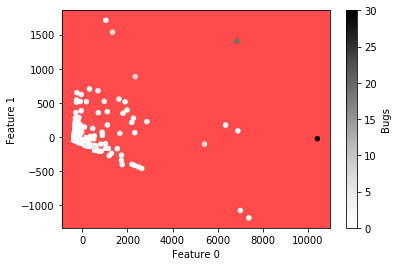

In [7]:
import pandas as pd
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np
import math

## read the data 
data = pd.read_csv('OO-DefectPrediction.csv')
## extact the features
features = data.drop('bug', axis=1)
## extract the labels
labels = data['bug']

pca = PCA(n_components=2)

## fit the model to the features
pca.fit(features)
## transform the features
features = pca.transform(features)

## create a Dataframe of the accuracies
df_features = pd.DataFrame(features)
df_labels = pd.DataFrame(labels)
df = pd.concat([df_features, df_labels], axis=1)
df.columns=['Feature 0', 'Feature 1', 'Bugs']
## plot the data, with the 'Bugs' column as the colour scale
fig = df.plot.scatter(x='Feature 0', y='Feature 1', c='Bugs', sharex=False)
## colour the plot red so you can see the lighter points clearly
fig.set_facecolor((1,0,0,0.7))

There are a smaller number of bugs when the values of Feature 0 and Feature 1 are closer to zero, and higher when either feature is a large positive value.